# Demonstrating Artifacts in an Image Colorization Model

We use a model pre-trained on Places365 available at https://github.com/shufanwu/colorNet-pytorch

More details on the model in the following article: <br>
Iizuka, et al. Let there be color! Joint end-to-end learning of global and local image priors for automatic image colorization with simultaneous classification. (SIGGRAPH 2016)

## Loading the Model (all layers use zero padding)

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

In [2]:
ckpt = torch.load("/work/data/pix2pix/ColorNet.pth.tar", map_location=torch.device('cpu'))

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class ColorizationNet(nn.Module):
    def __init__(self, midlevel_input_size=128, global_input_size=512):
        super(ColorizationNet, self).__init__()
        # Fusion layer to combine midlevel and global features
        self.midlevel_input_size = midlevel_input_size
        self.global_input_size = global_input_size
        self.fusion = nn.Linear(midlevel_input_size + global_input_size, midlevel_input_size)
        self.bn1 = nn.BatchNorm1d(midlevel_input_size)

        # Convolutional layers and upsampling
        self.deconv1_new = nn.ConvTranspose2d(midlevel_input_size, 128, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.Conv2d(midlevel_input_size, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1)
        self.upsample = nn.Upsample(scale_factor=2)

        print('Loaded colorization net.')

    def forward(self, midlevel_input): #, global_input):
        
        # Convolutional layers and upsampling
        x = F.relu(self.bn2(self.conv1(midlevel_input)))
        x = self.upsample(x)
        x = F.relu(self.bn3(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.upsample(x)
        x = F.sigmoid(self.conv4(x))
        x = self.upsample(self.conv5(x))
        return x


class ColorNet(nn.Module):
    def __init__(self):
        super(ColorNet, self).__init__()
        
        # Build ResNet and change first conv layer to accept single-channel input
        resnet_gray_model = models.resnet18(num_classes=365)
        resnet_gray_model.conv1.weight = nn.Parameter(resnet_gray_model.conv1.weight.sum(dim=1).unsqueeze(1).data)
        
        resnet_gray_weights = torch.load('/work/data/pix2pix/ColorNet_resnet_gray_weights.pth.tar', map_location=torch.device('cpu')) #torch.load('pretrained/resnet_gray.tar')['state_dict']
        resnet_gray_model.load_state_dict(resnet_gray_weights)
        print('Pretrained ResNet-gray weights loaded')

        # Extract midlevel and global features from ResNet-gray
        self.midlevel_resnet = nn.Sequential(*list(resnet_gray_model.children())[0:6])
        self.global_resnet = nn.Sequential(*list(resnet_gray_model.children())[0:9])
        self.fusion_and_colorization_net = ColorizationNet()

    def forward(self, input_image):

        # Pass input through ResNet-gray to extract features
        midlevel_output = self.midlevel_resnet(input_image)
        # global_output = self.global_resnet(input_image)

        # Combine features in fusion layer and upsample
        output = self.fusion_and_colorization_net(midlevel_output) #, global_output)
        return output


In [8]:
model = ColorNet()


Pretrained ResNet-gray weights loaded
Loaded colorization net.


In [9]:
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [ ]:
model.eval()


## Output and Average Feature Maps for 0-valued Input

In [11]:
activations = {}
def save_activation(name):
    def hook(mod, inp, out):
            activations[name] = out if type(out) is tuple else out.detach().numpy()
    return hook
    
for name, mod in model.named_modules():
    # if type(mod) == torch.nn.modules.conv.Conv2d:
    mod.register_forward_hook(save_activation(name))



In [12]:
outp = model(torch.zeros(1, 1, 256, 256))

/Users/bilalsal/miniconda3/envs/py35/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


### Computed pix2pix output showing sightly elevated output values close to the boundaries

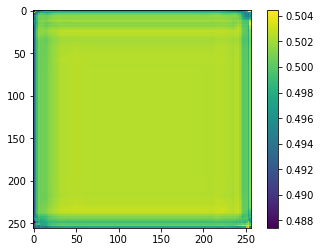

In [15]:
plt.imshow(outp[0].detach().numpy()[1])
plt.colorbar()

### Average Feature Maps showing artifacts

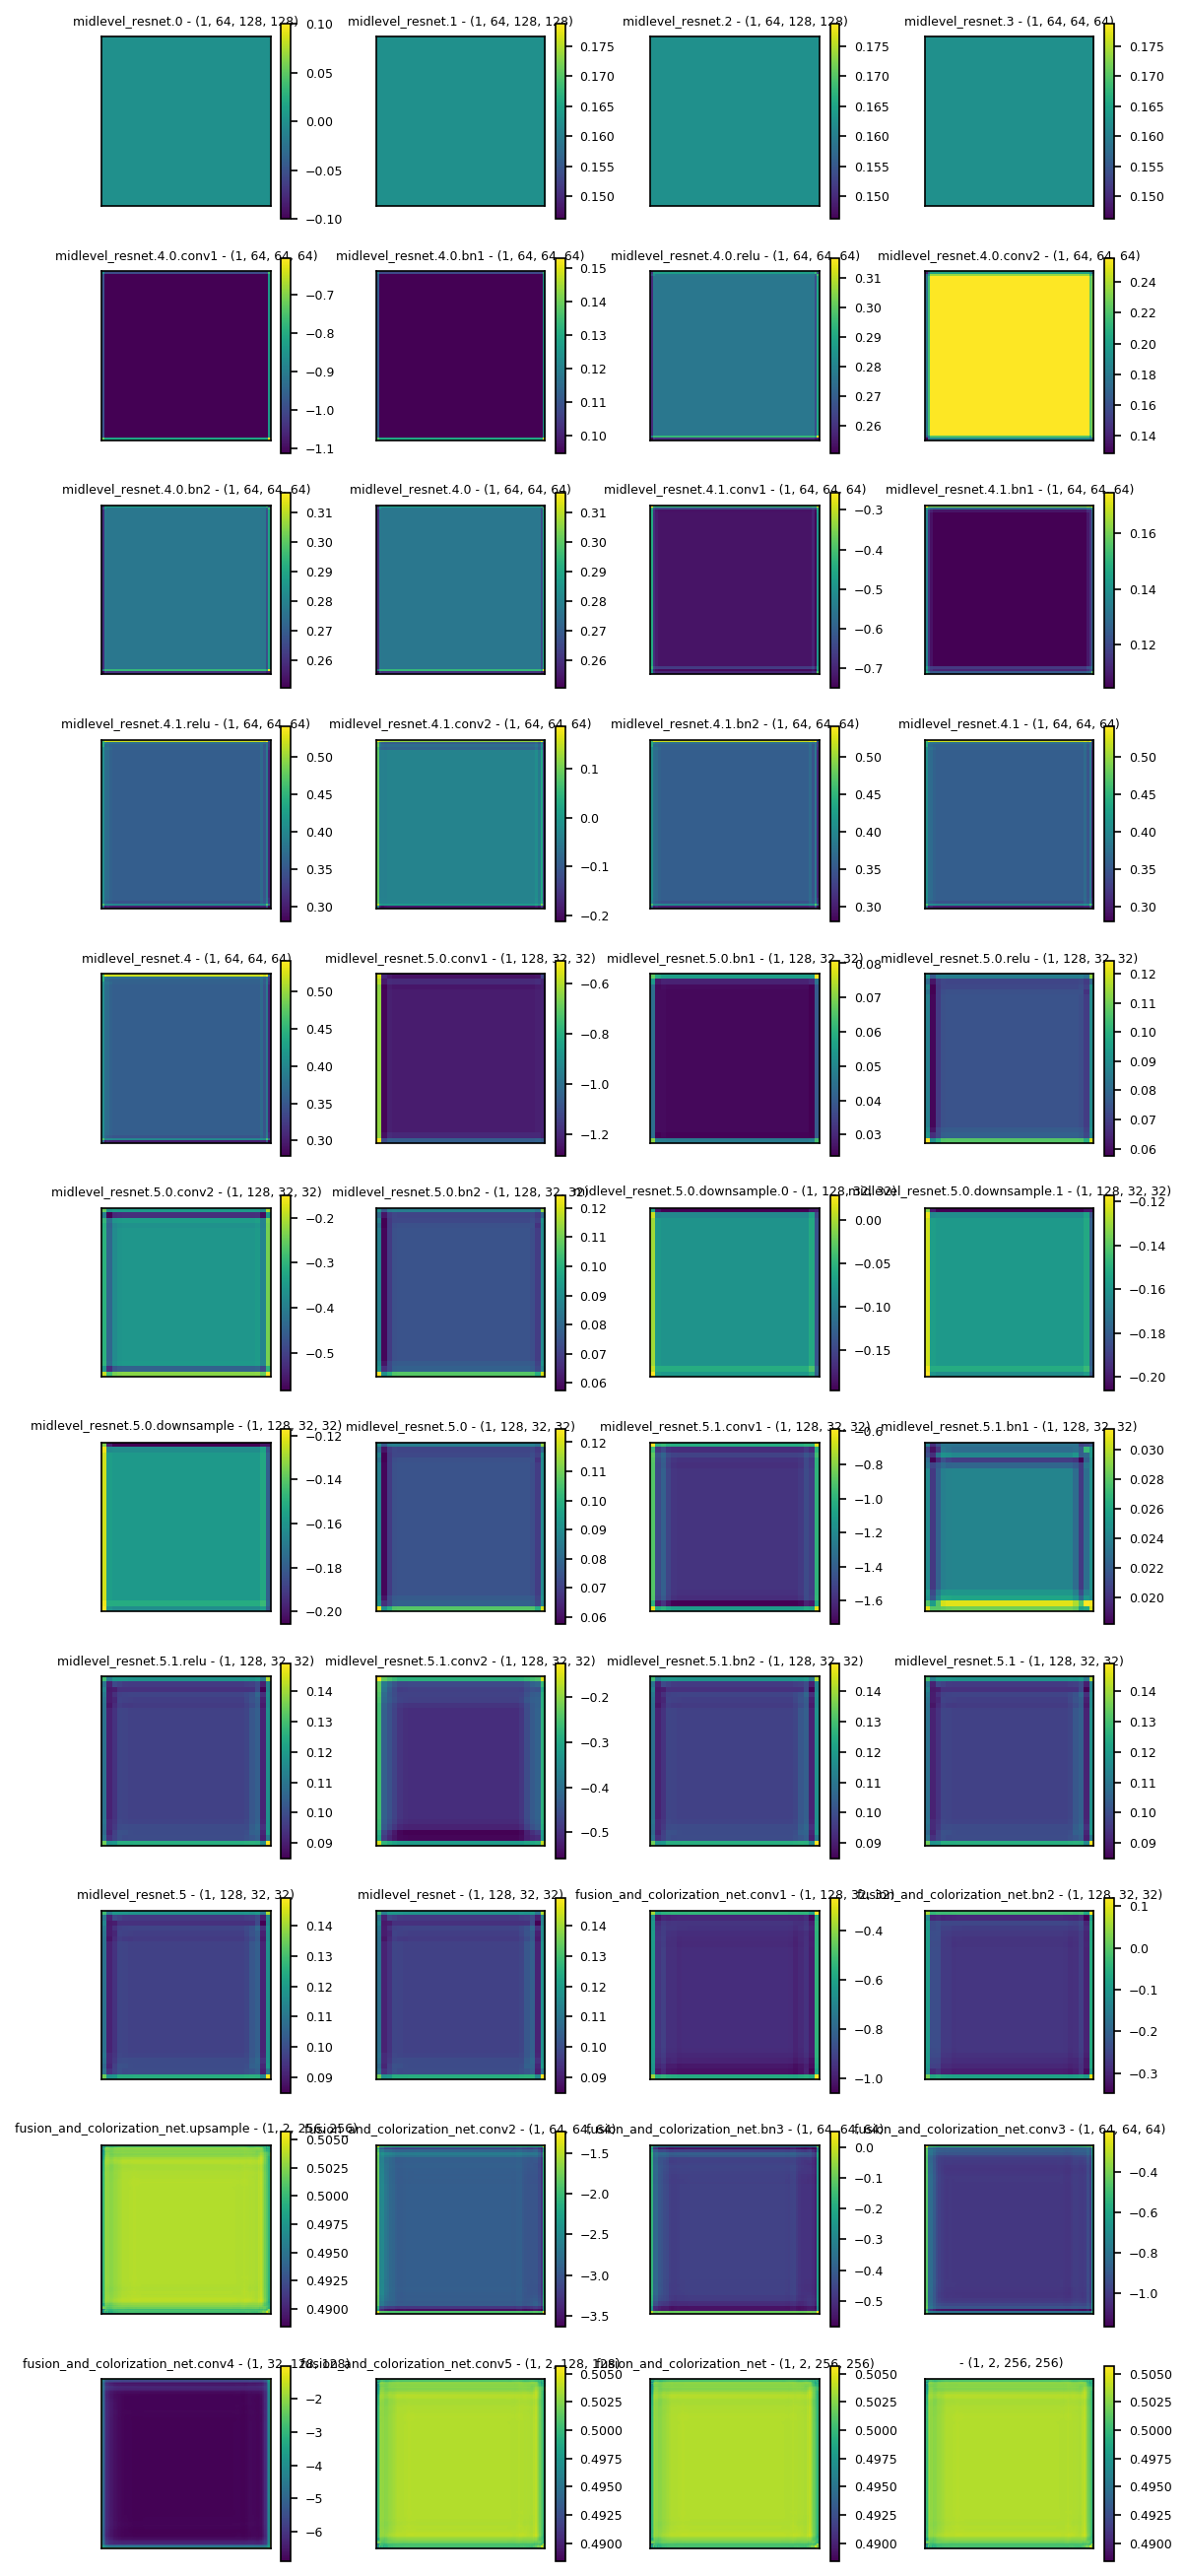

In [20]:
num_of_maps = len(activations)
fig = plt.figure(figsize=(7,25), dpi=150)
plt.subplots_adjust(left=0, bottom=0.1, right=1, top=0.85, wspace=0.3, hspace=0.2)
ind = 0
for key in activations:
    ax = fig.add_subplot(int(num_of_maps / 4) + 1, 4, ind + 1)
    avg_feat_map = np.mean(activations[key], axis=(0, 1))
    ax.set_title("{} - {}".format(key, activations[key].shape), fontsize=6)
    if len(avg_feat_map.shape) == 2: # fc layer
        plt.imshow(avg_feat_map)
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=6) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ind += 1




## Average Kernels

In [22]:
weight_mats = {}
total_sum_3x3 = np.zeros([3, 3])
total_sum_1x1 = 0
for name, mod in model.named_modules():
    if hasattr(mod, "weight"):
        weight_mat = mod.weight.detach().numpy()
        if (len(weight_mat.shape)) == 4:
            print("{} - {} - {}".format(weight_mat.shape, name, type(mod)))
            weight_mats[name] = np.sum(weight_mat, (0, 1))
            if len(weight_mats[name]) == 3:
                total_sum_3x3 += weight_mats[name]
            else:
                if len(weight_mats[name]) == 1:
                    total_sum_1x1 += np.sum(weight_mats[name])

(64, 1, 7, 7) - midlevel_resnet.0 - <class 'torch.nn.modules.conv.Conv2d'>
(64, 64, 3, 3) - midlevel_resnet.4.0.conv1 - <class 'torch.nn.modules.conv.Conv2d'>
(64, 64, 3, 3) - midlevel_resnet.4.0.conv2 - <class 'torch.nn.modules.conv.Conv2d'>
(64, 64, 3, 3) - midlevel_resnet.4.1.conv1 - <class 'torch.nn.modules.conv.Conv2d'>
(64, 64, 3, 3) - midlevel_resnet.4.1.conv2 - <class 'torch.nn.modules.conv.Conv2d'>
(128, 64, 3, 3) - midlevel_resnet.5.0.conv1 - <class 'torch.nn.modules.conv.Conv2d'>
(128, 128, 3, 3) - midlevel_resnet.5.0.conv2 - <class 'torch.nn.modules.conv.Conv2d'>
(128, 64, 1, 1) - midlevel_resnet.5.0.downsample.0 - <class 'torch.nn.modules.conv.Conv2d'>
(128, 128, 3, 3) - midlevel_resnet.5.1.conv1 - <class 'torch.nn.modules.conv.Conv2d'>
(128, 128, 3, 3) - midlevel_resnet.5.1.conv2 - <class 'torch.nn.modules.conv.Conv2d'>
(256, 128, 3, 3) - global_resnet.6.0.conv1 - <class 'torch.nn.modules.conv.Conv2d'>
(256, 256, 3, 3) - global_resnet.6.0.conv2 - <class 'torch.nn.modules.

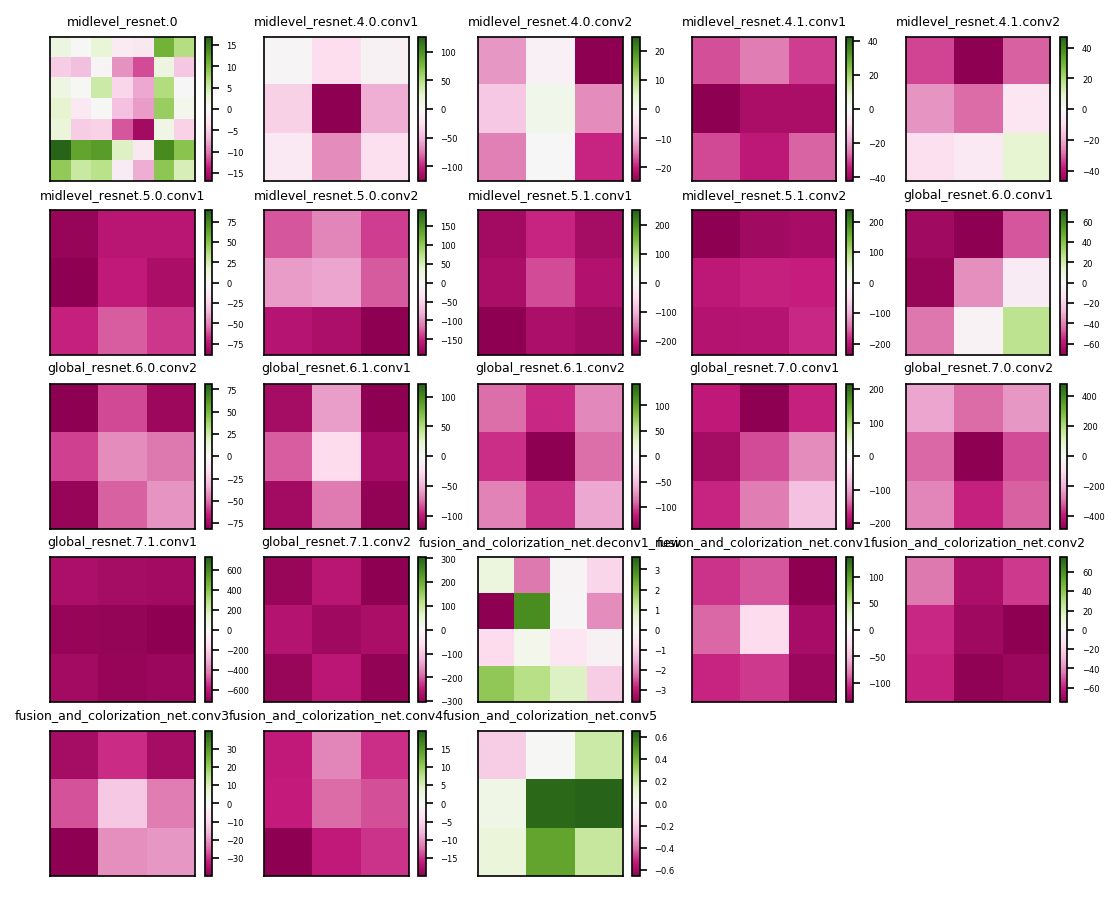

In [23]:

fig = plt.figure(figsize=(7, 9), dpi=150)
# fig.suptitle("classifier out map per class", fontsize=12)
plt.subplots_adjust(left=0, bottom=0.1, right=1, top=0.85, wspace=0.1, hspace=0.2)
ind = 0
for key in weight_mats:
    if len(weight_mats[key])== 1:
        continue
    ax = fig.add_subplot(len(weight_mats) / 5 + 1, 5, ind + 1)
    ax.set_title("{}".format(key), fontsize=6)
    
    vmin = np.min(weight_mats[key])
    vmax = np.max(weight_mats[key])
    max_abs = max(np.abs(vmin), np.abs(vmax))

    plt.imshow(weight_mats[key],vmin = -max_abs, vmax = max_abs, cmap=plt.get_cmap('PiYG'))
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=4) 
    ax.grid(b=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ind += 1